<a href="https://colab.research.google.com/github/PrinceArya/Classification-of-Horticulture-plantations-using-hyperspectral-Images-and-Area-Estimation./blob/master/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/f/f1/Salinas.mat

--2021-03-07 09:27:15--  http://www.ehu.eus/ccwintco/uploads/f/f1/Salinas.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27605707 (26M)
Saving to: ‘Salinas.mat’

Salinas.mat         100%[===================>]  26.33M   503KB/s    in 54s     

2021-03-07 09:28:11 (497 KB/s) - ‘Salinas.mat’ saved [27605707/27605707]



In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat

--2021-03-07 09:28:11--  http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26552770 (25M)
Saving to: ‘Salinas_corrected.mat’

Salinas_corrected.m 100%[===================>]  25.32M   519KB/s    in 50s     

2021-03-07 09:29:02 (516 KB/s) - ‘Salinas_corrected.mat’ saved [26552770/26552770]



In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat

--2021-03-07 09:29:02--  http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277 (4.2K)
Saving to: ‘Salinas_gt.mat’

Salinas_gt.mat      100%[===================>]   4.18K  --.-KB/s    in 0s      

2021-03-07 09:29:02 (418 MB/s) - ‘Salinas_gt.mat’ saved [4277/4277]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import scipy.io as sio
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1024
seed_torch(seed)

In [ ]:
Dir = "/content/"
random_state = 97
batch_size=16
patch_size=9
no_class = 16
depth = 20

#Preprocessing

In [ ]:
def Padding(X, margin):
    Padded_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    Padded_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return Padded_X


In [ ]:
def Create3Dpatch(X, y, patch=patch_size, removeZeroLabels = True):
    margin = int((patch - 1) / 2)
    Padded_X = Padding(X, margin=margin)
    # split patches
    New_Data = np.zeros((X.shape[0] * X.shape[1], patch, patch, X.shape[2]))
    New_Label = np.zeros((X.shape[0] * X.shape[1]))
    index = 0
    for row in range(margin, Padded_X.shape[0] - margin):
        for col in range(margin, Padded_X.shape[1] - margin):
            patch = Padded_X[row - margin:row + margin + 1, col - margin:col + margin + 1]   
            New_Data[index, :, :, :] = patch
            New_Label[index] = y[row-margin, col-margin]
            index = index + 1
    if removeZeroLabels:
        New_Data = New_Data[New_Label>0,:,:,:]
        New_Label = New_Label[New_Label>0]
        New_Label -= 1
    return New_Data, New_Label

In [ ]:
def Count_Label(y, n_class):
  Count= [0] * n_class
  Count = np.array(Count)
  for i in range(y.shape[0]):
    idx = int(y[i])
    Count[idx] +=1

  for i in range(n_class):
    print("Class "+str(i)+" == ","{0:.2f}".format((Count[i]/y.shape[0])*100), "%")


#DataLoader

In [ ]:
class Data(Dataset):
  def __init__(self,Dir,feature,labels,patch,band):
    self.feature =feature
    self.labels = labels
    #self.transform = transform
    self.patch = patch
    self.band = band
    self.len = feature.shape[0]
  def __len__(self):
    return self.len;
  def __getitem__(self,idx):
    X = torch.from_numpy(np.array(self.feature[idx]))
    X = X.resize(self.patch,self.patch,self.band,1)
    X = X.permute(3,2,0,1)
    X = X.type(torch.double)
    y = torch.from_numpy(np.array(self.labels[idx]))
    return X,y

In [ ]:
feature = sio.loadmat(os.path.join(Dir, 'Salinas_corrected.mat'))['salinas_corrected']
labels = sio.loadmat(os.path.join(Dir, 'Salinas_gt.mat'))['salinas_gt']

###PCA 

In [ ]:
from sklearn.decomposition import PCA

def Apply_PCA_on_Depth(X, depth):
    X_new = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=depth, whiten=True)
    X_new = pca.fit_transform(X_new)
    X_new = np.reshape(X_new, (X.shape[0],X.shape[1], depth))
    return X_new, pca

In [ ]:
feature,pca = Apply_PCA_on_Depth(feature,depth)
feature.shape

(512, 217, 20)

In [ ]:
feature,labels = Create3Dpatch(feature,labels)

In [ ]:
feature.shape

(54129, 9, 9, 20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.3, random_state=random_state,stratify=labels)

In [ ]:
Count_Label(y_train, 16)  #Class is imbalance

Class 0 ==  3.71 %
Class 1 ==  6.88 %
Class 2 ==  3.65 %
Class 3 ==  2.58 %
Class 4 ==  4.95 %
Class 5 ==  7.31 %
Class 6 ==  6.61 %
Class 7 ==  20.82 %
Class 8 ==  11.46 %
Class 9 ==  6.06 %
Class 10 ==  1.97 %
Class 11 ==  3.56 %
Class 12 ==  1.69 %
Class 13 ==  1.98 %
Class 14 ==  13.43 %
Class 15 ==  3.34 %


In [ ]:
Count_Label(y_test, 16)

Class 0 ==  3.71 %
Class 1 ==  6.88 %
Class 2 ==  3.65 %
Class 3 ==  2.57 %
Class 4 ==  4.94 %
Class 5 ==  7.32 %
Class 6 ==  6.61 %
Class 7 ==  20.82 %
Class 8 ==  11.46 %
Class 9 ==  6.05 %
Class 10 ==  1.97 %
Class 11 ==  3.56 %
Class 12 ==  1.69 %
Class 13 ==  1.98 %
Class 14 ==  13.43 %
Class 15 ==  3.34 %


In [ ]:
print(X_train.shape)
print(X_test.shape)

(37890, 9, 9, 20)
(16239, 9, 9, 20)


###Oversampling

In [ ]:
!sudo pip install imbalanced-learn

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

def OverSampling(X, y):
  dim1 = X.shape[1]
  dim2 = X.shape[2]
  dim3 = X.shape[3]
  X = np.reshape(X,(X.shape[0],dim1*dim2*dim3))
  smote = SMOTE()
  X_smote, y_smote = smote.fit_resample(X, y)
  X_smote = np.reshape(X_smote,(X_smote.shape[0],dim1,dim2,dim3))
  return X_smote,y_smote, smote


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X_train, y_train, smote = OverSampling(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
Count_Label(y_train, 16)   #Class Balanced

Class 0 ==  6.25 %
Class 1 ==  6.25 %
Class 2 ==  6.25 %
Class 3 ==  6.25 %
Class 4 ==  6.25 %
Class 5 ==  6.25 %
Class 6 ==  6.25 %
Class 7 ==  6.25 %
Class 8 ==  6.25 %
Class 9 ==  6.25 %
Class 10 ==  6.25 %
Class 11 ==  6.25 %
Class 12 ==  6.25 %
Class 13 ==  6.25 %
Class 14 ==  6.25 %
Class 15 ==  6.25 %


In [ ]:
X_train.shape

In [ ]:
train_dataset = Data(Dir,X_train,y_train,patch=patch_size,band=depth)
validation_dataset = Data(Dir,X_test,y_test,patch=patch_size,band=depth)

In [ ]:
train_dataset[1400][0].shape

In [ ]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

valid_data_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
import torch.nn as nn
import torch.nn.functional as fun
import matplotlib.pyplot as plt

#Model

In [ ]:
class HSI_Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=(3,3,3))
    self.batchnorm1 = nn.BatchNorm3d(8)
    self.conv2 = nn.Conv3d(in_channels=8, out_channels=16, kernel_size=(5,3,3))
    self.batchnorm2 = nn.BatchNorm3d(16)
    self.conv3 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(5,3,3))
    self.batchnorm3 = nn.BatchNorm3d(32)
    self.fc1 = nn.Linear(32*10*3*3,512)
    self.fc2 = nn.Linear(512,no_class)
    self.relu = nn.ReLU()
  def forward(self, x):
    layer0 = self.relu(self.conv1(x))
    layer0 = self.batchnorm1(layer0)
    layer1 = self.relu(self.conv2(layer0))
    layer1 = self.batchnorm2(layer1)
    layer2 = self.relu(self.conv3(layer1))
    layer2 = self.batchnorm3(layer2)
    layer2 = layer2.view(-1,layer2.size(1)*layer2.size(2)*layer2.size(3)*layer2.size(4))
    layer3 = torch.tanh(self.fc1(layer2))
    layer4 = self.fc2(layer3)
    return layer4

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
model = HSI_Classifier()
model = model.apply(weights_init)

In [ ]:
model(train_dataset[1][0].resize(1,1,20,9,9).float())

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[ 0.0001, -0.0096, -0.0003, -0.0426,  0.0253,  0.0461,  0.0237, -0.0302,
         -0.0184,  0.0356,  0.0053,  0.0318, -0.0262,  0.0424, -0.0204, -0.0362]],
       grad_fn=<AddmmBackward>)

In [ ]:
model

HSI_Classifier(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batchnorm1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(8, 16, kernel_size=(5, 3, 3), stride=(1, 1, 1))
  (batchnorm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1))
  (batchnorm3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2880, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
  (relu): ReLU()
)

In [ ]:
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lmbda = lambda epoch: 0.97  #lr_new_epoch = lr_prev_epoch*0.90
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
pth = "/content/drive/MyDrive/HyperSpectral_Model_With_Oversampling_3.pth"

# Model Training

In [ ]:
def train(model, criterion, train_loader, validation_loader, optimizer, epochs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    i = 0
    model.to(device)
    history = {'training_loss': [],'validation_accuracy': [], 'validation_loss':[]}
    for epoch in tqdm(range(epochs)):
        t_loss=0
        v_loss=0
        for i, (X, y) in enumerate(train_loader): 
            model.train()
            X = X.to(device).float()
            y = y.to(device).type(torch.long)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            t_loss +=loss.data.item()
        correct = 0
        for x_valid, y_valid in validation_loader:
            #validation 
            model.eval()
            x_valid = x_valid.to(device).float()
            y_valid = y_valid.to(device).type(torch.long)
            z = model(x_valid)
            val_loss = criterion(z, y_valid)
            v_loss+=val_loss.data.item()
            _, label = torch.max(z, 1)
            correct += (label == y_valid).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        history['validation_accuracy'].append(accuracy)
        history['training_loss'].append(t_loss/len(train_dataset))
        history['validation_loss'].append(v_loss/len(validation_dataset))
        print("Epoch ::::  "+str(epoch+1)+"  train_loss ::: "+str(t_loss/len(train_dataset))+"  valid_loss :::"+str(v_loss/len(validation_dataset))+"  Validation_Accuracy ::: "+str(accuracy))
        for param_group in optimizer.param_groups:
          print("Current Learning Rate:",param_group['lr'])
        scheduler.step()
        torch.save({'model': model,
               'optimizer': optimizer,},
                pth)
    return history

In [ ]:
hist = train(model,criterion,train_data_loader,valid_data_loader,optimizer,epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch ::::  1  train_loss ::: 8.790274205978069e-05  valid_loss :::9.631151691755861e-05  Validation_Accuracy ::: 99.96920992671963
Current Learning Rate: 0.001
Epoch ::::  2  train_loss ::: 8.383316238771849e-05  valid_loss :::0.00029038070984603327  Validation_Accuracy ::: 99.9014717655028
Current Learning Rate: 0.0009699999999999999
Epoch ::::  3  train_loss ::: 5.853480978613934e-05  valid_loss :::8.852513958099433e-05  Validation_Accuracy ::: 99.98152595603177
Current Learning Rate: 0.0009408999999999999
Epoch ::::  4  train_loss ::: 6.117343280213726e-05  valid_loss :::0.0001292921629082869  Validation_Accuracy ::: 99.98152595603177
Current Learning Rate: 0.0009126729999999999
Epoch ::::  5  train_loss ::: 4.2981850255320605e-05  valid_loss :::0.00036613980160356036  Validation_Accuracy ::: 99.9014717655028
Current Learning Rate: 0.0008852928099999999
Epoch ::::  6  train_loss ::: 6.464601536649923e-05  valid_loss :::1.6850266525756644e-05  Validation_Accuracy ::: 99.987683970687

In [ ]:
def plot_accuracy_loss(training_results): 
    plt.subplot(3, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('train_loss')
    plt.title('training loss per iterations')

    plt.subplot(3, 1, 2)
    plt.plot(training_results['validation_loss'], 'g')
    plt.ylabel('validation_loss')

    plt.subplot(3, 1, 3)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

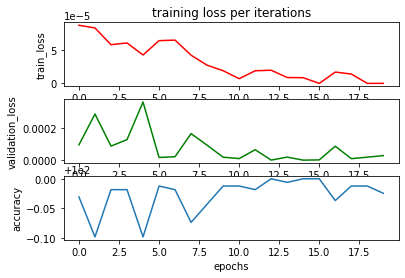

In [ ]:
plot_accuracy_loss(hist)

In [ ]:
!pip install spectral

     |████████████████████████████████| 215kB 8.5MB/s 


In [ ]:
import spectral
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

In [ ]:
checkpoint = "/content/drive/MyDrive/HyperSpectral_Model_With_Oversampling_3.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Classification Report on test data

In [ ]:
def Evaluate_On_test_Data(checkpoint, X_test, y_test):
  model= torch.load(checkpoint)['model'].to(device)
  model.eval()

  X_test = torch.from_numpy(X_test)
  X_test = X_test.resize(X_test.shape[0],patch_size,patch_size,depth,1)
  X_test = X_test.permute(0,4,3,2,1)

  pred = model(X_test.float().to(device))
  pred = pred.detach().cpu().numpy()

  y_pred_validation = np.argmax(pred, axis=1)
  report = classification_report(y_test, y_pred_validation)
  return report





In [ ]:
class_report = Evaluate_On_test_Data(checkpoint, X_test, y_test)
print(class_report)

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       603
         1.0       1.00      1.00      1.00      1118
         2.0       0.99      1.00      0.99       593
         3.0       0.80      0.87      0.83       418
         4.0       0.93      0.88      0.90       803
         5.0       1.00      0.99      1.00      1188
         6.0       0.99      1.00      1.00      1074
         7.0       0.99      0.99      0.99      3381
         8.0       1.00      1.00      1.00      1861
         9.0       1.00      1.00      1.00       983
        10.0       1.00      1.00      1.00       320
        11.0       1.00      1.00      1.00       578
        12.0       0.99      1.00      0.99       275
        13.0       0.98      0.99      0.99       321
        14.0       0.99      0.98      0.99      2181
        15.0       1.00      0.99      1.00       542

    accuracy                           0.99     16239
   macro avg       0.98   

#Generating crop map from predicted label

In [ ]:
def Create_Patch(data,height_index,width_index):
    h_slice = slice(height_index, height_index+patch_size)
    w_slice = slice(width_index, width_index+patch_size)
    patched_data = data[h_slice, w_slice, :]
    return patched_data

In [ ]:
feature = sio.loadmat(os.path.join(Dir, 'Salinas_corrected.mat'))['salinas_corrected']
label = sio.loadmat(os.path.join(Dir, 'Salinas_gt.mat'))['salinas_gt']

In [ ]:
feature,pca = Apply_PCA_on_Depth(feature, depth)

In [ ]:
height = label.shape[0]
width = label.shape[1]
feature = Padding(feature, patch_size//2)

In [ ]:
def load_pretrained_model(pretrained, checkpoint):
  model = HSI_Classifier()
  if pretrained:
     model = torch.load(checkpoint)['model']
     
  return model
    

In [ ]:
model = load_pretrained_model(True,checkpoint).to(device)

In [ ]:
model.eval()

HSI_Classifier(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batchnorm1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(8, 16, kernel_size=(5, 3, 3), stride=(1, 1, 1))
  (batchnorm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1))
  (batchnorm3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2880, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
  (relu): ReLU()
)

In [ ]:
predicted_output = np.zeros((height,width))
for h in range(height):
  for w in range(width):
    true_label = int(label[h,w])
    if (true_label!=0):
      patch_image = Create_Patch(feature,h,w)
      patch_image = torch.from_numpy(patch_image)
      patch_image = patch_image.resize(1,patch_image.shape[0],patch_image.shape[1],patch_image.shape[2],1)
      patch_image = patch_image.permute(0,4,3,2,1).to(device)
      predict = model(patch_image.float())
      predict = predict.detach().cpu().numpy()
      predict = np.argmax(predict, axis=1)
      predicted_output[h][w] = predict+1





/usr/local/lib/python3.7/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


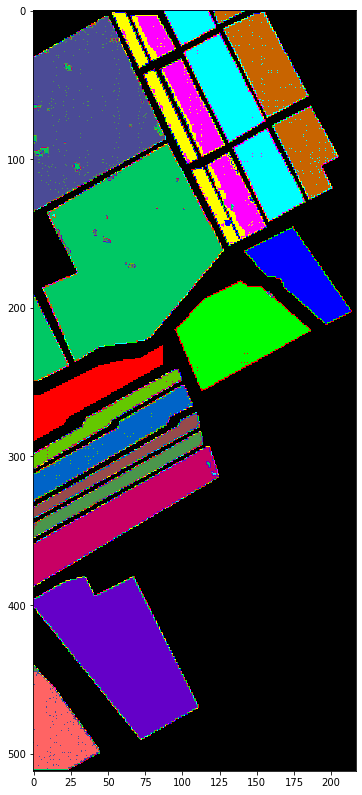

In [ ]:
predicted_segmentation = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,14))

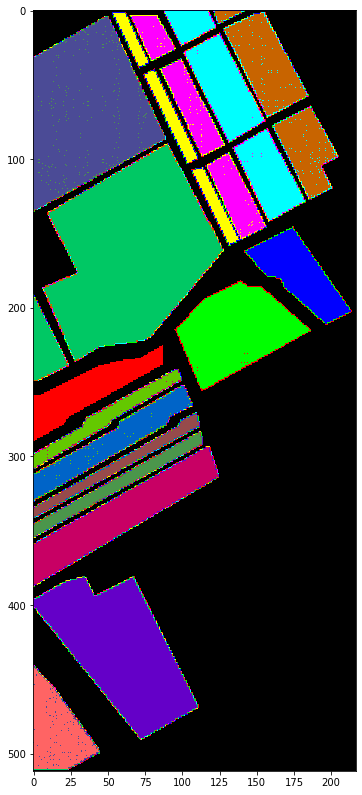

In [ ]:
ground_truth_Segmentation = spectral.imshow(classes = label,figsize =(7,14))  

#Area Estimation

In [ ]:
def Estimate_Area(spatial_resolution, label, n_class, class_to_crop_name_mapping):
  Count = [0]* n_class
  Count = np.array(Count)
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      idx = int(label[i][j])
      Count[idx] +=1

  area_of_one_pixel = float(spatial_resolution * spatial_resolution)
  for i in range(n_class):
    print("Area of "+class_to_crop_name_mapping[i]+" == ","{0:.2f}".format((Count[i]*area_of_one_pixel)), "square metre")





In [ ]:
class_to_crop_name_mapping = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']

spatial_resolution_of_salinas_dataset = 3.7
predicted_output = predicted_output -1

In [ ]:
Estimate_Area(spatial_resolution_of_salinas_dataset, predicted_output, 16, class_to_crop_name_mapping)

Area of Brocoli_green_weeds_1 ==  50926.80 square metre
Area of Brocoli_green_weeds_2 ==  27448.45 square metre
Area of Fallow ==  20726.66 square metre
Area of Fallow_rough_plow ==  34622.01 square metre
Area of Fallow_smooth ==  54034.43 square metre
Area of Stubble ==  49174.48 square metre
Area of Celery ==  154779.14 square metre
Area of Grapes_untrained ==  84973.83 square metre
Area of Soil_vinyard_develop ==  44807.37 square metre
Area of Corn_senesced_green_weeds ==  14620.92 square metre
Area of Lettuce_romaine_4wk ==  26380.63 square metre
Area of Lettuce_romaine_5wk ==  12608.49 square metre
Area of Lettuce_romaine_6wk ==  14826.27 square metre
Area of Lettuce_romaine_7wk ==  99006.08 square metre
Area of Vinyard_untrained ==  804574.99 square metre
Area of Vinyard_vertical_trellis ==  27503.21 square metre


#Transfer Learning

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat

--2021-03-07 11:10:24--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M   525KB/s    in 67s     

2021-03-07 11:11:31 (510 KB/s) - ‘PaviaU.mat’ saved [34806917/34806917]



In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2021-03-07 11:11:34--  http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
Saving to: ‘PaviaU_gt.mat’

PaviaU_gt.mat       100%[===================>]  10.75K  --.-KB/s    in 0s      

2021-03-07 11:11:34 (310 MB/s) - ‘PaviaU_gt.mat’ saved [11005/11005]



In [ ]:
feature = sio.loadmat("/content/PaviaU.mat")['paviaU']
label = sio.loadmat("/content/PaviaU_gt.mat")['paviaU_gt']

In [ ]:
feature,pca = Apply_PCA_on_Depth(feature,depth)
feature.shape

(610, 340, 20)

In [ ]:
feature,labels = Create3Dpatch(feature,label)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.3, random_state=random_state,stratify=labels)

In [ ]:
train_dataset = Data(Dir,X_train,y_train,patch=patch_size,band=depth)
validation_dataset = Data(Dir,X_test,y_test,patch=patch_size,band=depth)

In [ ]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

valid_data_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
pth = "/content/drive/MyDrive/HyperSpectral_Model_With_Oversampling.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = load_pretrained_model(True,pth).to(device)

In [ ]:
model.fc2 = nn.Linear(512, 9)

In [ ]:
 for param in model.parameters():
     param.requires_grad = False

In [ ]:
 model.fc1.weight.requires_grad = True
 model.fc1.bias.requires_grad = True
 model.fc2.weight.requires_grad = True
 model.fc2.bias.requires_grad = True

In [ ]:

import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm_notebook as tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
lmbda = lambda epoch: 0.97  #lr_new_epoch = lr_prev_epoch*0.90
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [ ]:
def train(model, train_loader, validation_loader, optimizer, epochs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    i = 0
    model.to(device)
    history = {'training_loss': [],'validation_accuracy': [], 'validation_loss':[]}
    for epoch in tqdm(range(epochs)):
        t_loss=0
        v_loss=0
        for i, (X, y) in enumerate(train_loader): 
            model.train()
            X = X.to(device).float()
            y = y.to(device).type(torch.long)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            t_loss +=loss.data.item()
        correct = 0
        for x_valid, y_valid in validation_loader:
            #validation 
            model.eval()
            x_valid = x_valid.to(device).float()
            y_valid = y_valid.to(device).type(torch.long)
            z = model(x_valid)
            val_loss = criterion(z, y_valid)
            v_loss+=val_loss.data.item()
            _, label = torch.max(z, 1)
            correct += (label == y_valid).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        history['validation_accuracy'].append(accuracy)
        history['training_loss'].append(t_loss/len(train_dataset))
        history['validation_loss'].append(v_loss/len(validation_dataset))
        print("Epoch ::::  "+str(epoch+1)+"  train_loss ::: "+str(t_loss/len(train_dataset))+"  valid_loss :::"+str(v_loss/len(validation_dataset))+"  Validation_Accuracy ::: "+str(accuracy))
        for param_group in optimizer.param_groups:
          print("Current Learning Rate:",param_group['lr'])
        scheduler.step()
    return history

In [ ]:
hist = train(model,train_data_loader,valid_data_loader,optimizer,epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch ::::  1  train_loss ::: 0.006422422398302572  valid_loss :::0.0014498965480976064  Validation_Accuracy ::: 99.40777682537208
Current Learning Rate: 0.001
Epoch ::::  2  train_loss ::: 0.0008826983929644595  valid_loss :::0.0006328004357310218  Validation_Accuracy ::: 99.72726564326346
Current Learning Rate: 0.0009699999999999999
Epoch ::::  3  train_loss ::: 0.0003712522840798404  valid_loss :::0.0004508562326794078  Validation_Accuracy ::: 99.81298215538065
Current Learning Rate: 0.0009408999999999999
Epoch ::::  4  train_loss ::: 0.00036354065863076145  valid_loss :::0.000262385911117536  Validation_Accuracy ::: 99.88311384711291
Current Learning Rate: 0.0009126729999999999
Epoch ::::  5  train_loss ::: 0.0001945526953707658  valid_loss :::0.000390539702492404  Validation_Accuracy ::: 99.82856697576561
Current Learning Rate: 0.0008852928099999999
Epoch ::::  6  train_loss ::: 0.0001486455182025957  valid_loss :::0.0003088073882935715  Validation_Accuracy ::: 99.82077456557313
C

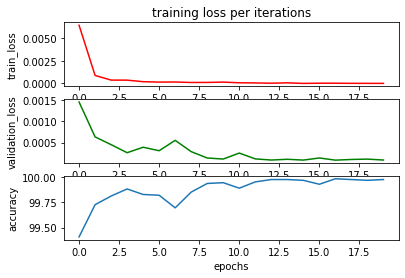

In [ ]:
plot_accuracy_loss(hist)

In [ ]:
def Evaluate_On_test_Data(model, X_test, y_test):
  model.eval()

  X_test = torch.from_numpy(X_test)
  X_test = X_test.resize(X_test.shape[0],patch_size,patch_size,depth,1)
  X_test = X_test.permute(0,4,3,2,1)

  pred = model(X_test.float().to(device))
  pred = pred.detach().cpu().numpy()

  y_pred_validation = np.argmax(pred, axis=1)
  report = classification_report(y_test, y_pred_validation)
  return report





In [ ]:
result = Evaluate_On_test_Data(model,X_test,y_test)
print(result)

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1989
         1.0       1.00      1.00      1.00      5595
         2.0       0.93      0.95      0.94       630
         3.0       0.99      0.99      0.99       919
         4.0       1.00      1.00      1.00       403
         5.0       1.00      1.00      1.00      1509
         6.0       0.98      1.00      0.99       399
         7.0       0.94      0.95      0.95      1105
         8.0       0.98      0.99      0.99       284

    accuracy                           0.99     12833
   macro avg       0.98      0.98      0.98     12833
weighted avg       0.99      0.99      0.99     12833



In [ ]:
feature = sio.loadmat("/content/PaviaU.mat")['paviaU']
label = sio.loadmat("/content/PaviaU_gt.mat")['paviaU_gt']

In [ ]:
feature,pca = Apply_PCA_on_Depth(feature, depth)

In [ ]:
height = label.shape[0]
width = label.shape[1]
feature = Padding(feature, patch_size//2)

In [ ]:
#model = load_pretrained_model(True,pth).to(device)

In [ ]:
model.eval()

HSI_Classifier(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batchnorm1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(8, 16, kernel_size=(5, 3, 3), stride=(1, 1, 1))
  (batchnorm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1))
  (batchnorm3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2880, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
  (relu): ReLU()
)

In [ ]:
predicted_output = np.zeros((height,width))
for h in range(height):
  for w in range(width):
    true_label = int(label[h,w])
    if (true_label!=0):
      patch_image = Create_Patch(feature,h,w)
      patch_image = torch.from_numpy(patch_image)
      patch_image = patch_image.resize(1,patch_image.shape[0],patch_image.shape[1],patch_image.shape[2],1)
      patch_image = patch_image.permute(0,4,3,2,1).to(device)
      predict = model(patch_image.float())
      predict = predict.detach().cpu().numpy()
      predict = np.argmax(predict, axis=1)
      predicted_output[h][w] = predict+1


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


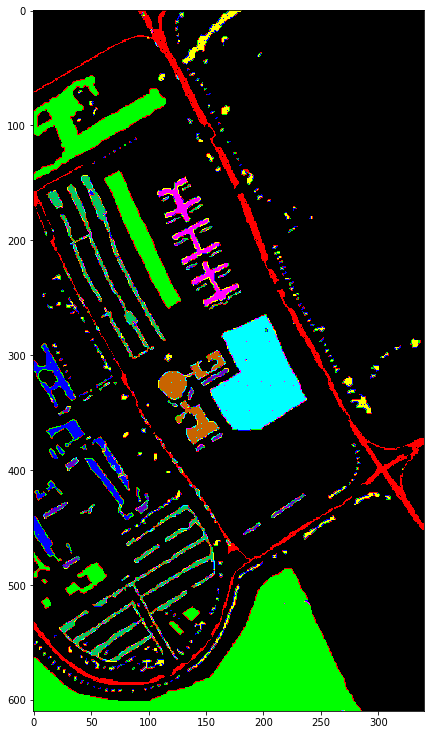

In [ ]:
predicted_segmentation = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,14))

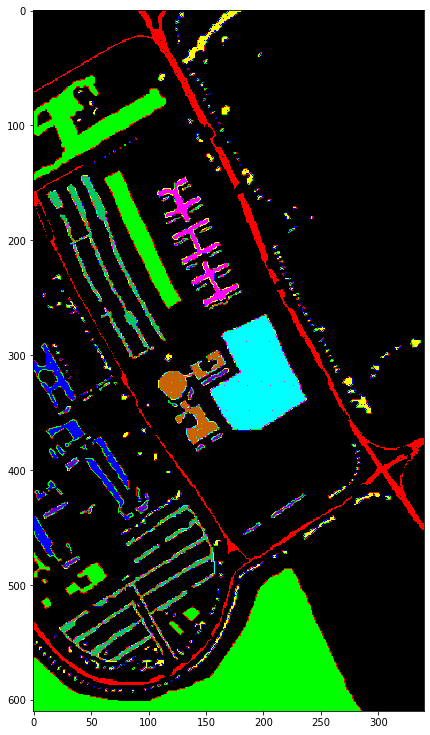

In [ ]:
ground_truth_Segmentation = spectral.imshow(classes = label,figsize =(7,14))  